<center><h1>Data Augmentation</h1></center>

Various methods have been conceived for audio data augmentation. Some are performed on spectrograms and others on the raw audio.

The methods I will use are:
  * [White noise](#white-noise)
  * [Spectrogram augmentation using Google Brain SpecAugment](#spec-augment)

I like these augmentation methods because I expect they should make the model more robust to messy data, like missing frequencies, cuts in audio and noisy audio. 

In [4]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import tensorflow as tf
import glob
import os
from IPython.display import Audio, display, clear_output
import matplotlib.pyplot as plt

In [5]:
train_df = pd.read_csv("challengeA_data/2022challengeA_train_modified.csv", index_col=[0])

<a id="white-noise"></a>
<h2>White noise</h2>

In [26]:
def add_white_noise(waveform, noise_factor):
    noise = np.random.normal(0, waveform.std(), len(waveform))
    noisy_signal = waveform + noise * noise_factor
    return noisy_signal

I now preview audio clips from each source to check if adding more noise might lead to uninterpretable audio.

In [48]:
current_class = None
prev_class = None
for index, row in train_df.sample(frac=1).groupby("origin").head(2).sort_values(by="origin").iterrows():
    current_class = row["origin"]
    if current_class != prev_class:
        print("Corpus:", current_class)
    file = row["file_id"]
    file_path = os.path.join("challengeA_data", "train", file)
    audio, _ = librosa.load(file_path, sr=16000)
    display(Audio(audio, rate=16000))
    prev_class = current_class

Corpus: crema


Corpus: ravdess


Corpus: savee


Corpus: tess


What I've found is that the crema corpus is already very noisy, so I won't augment the data using noise addition with audio from that corpus. The others appear to be much clearer, so I will add noise to the rest and then create more audio files. <br>
<br>
Looking at the counts of the number of audio files from each corpus, I can see how much more data I can get from this method. 

In [47]:
train_df.groupby("origin").count()

,file_id,emotion,encoded_emotion,duration,sample_rate,n_channels
origin,,,,,,
crema,6306,6306,6306,6306,6306,6306
ravdess,1041,1041,1041,1041,1041,1041
savee,397,397,397,397,397,397
tess,2366,2366,2366,2366,2366,2366


In [49]:
1041 + 397 + 2366

3804

I will create one additional noisy audio file with each instance in the ravdess, savee and tess corpora, yielding a total of 3804 additional audio files. But before I do that, I want to preview what noise addition does to some of the audio files to make sure that the speech is still sufficiently audible. 

In [68]:
random_subset = train_df[train_df["origin"] != "crema"].groupby("origin").head(1).sort_values(by="origin")
files_dict = dict(zip(list(random_subset["origin"].values), list(random_subset["file_id"].values)))
noise_factor = 0.02
count = 0
for origin, file in files_dict.items():
    print(origin)
    file_path = os.path.join("challengeA_data", "train", file)
    audio, sr = librosa.load(file_path, sr=16000)
    noisy_audio = add_white_noise(audio, noise_factor)
    
    print("Original audio:")
    display(Audio(audio, rate=sr))
    
    print(f"Noisy audio (noise_factor={noise_factor}):")
    display(Audio(noisy_audio, rate=sr))
    
    count += 1
    print('-' * 30 if count < 3 else "")
    
    

ravdess
Original audio:


Noisy audio (noise_factor=0.02):


------------------------------
savee
Original audio:


Noisy audio (noise_factor=0.02):


------------------------------
tess
Original audio:


Noisy audio (noise_factor=0.02):


I also want to preview its effects on mel spectrograms at different noise factors to see how much noise I should apply.

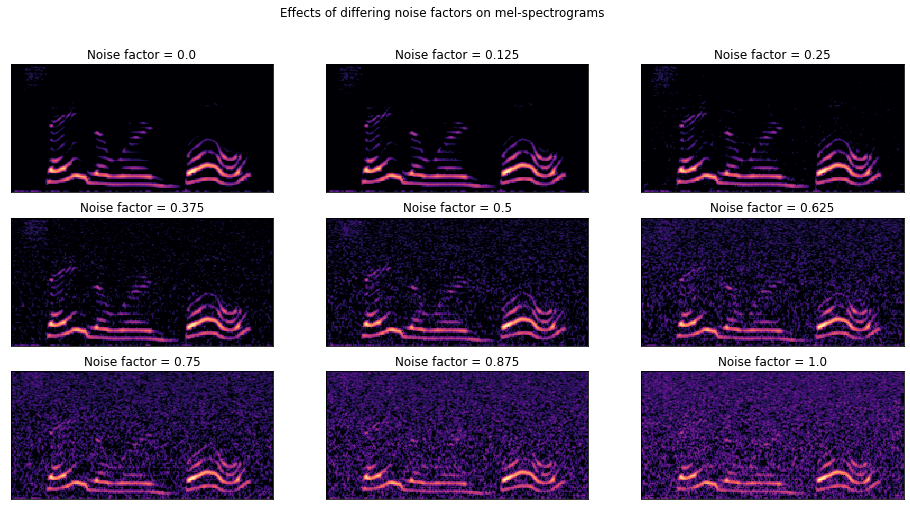

In [97]:
frame_size = 512
hop_length = 128
sr = 16000
def mel_specgram(waveform):
    mel_specgram = librosa.feature.melspectrogram(y=waveform, n_fft=frame_size, hop_length=hop_length, sr=sr)
    mel_specgram = librosa.amplitude_to_db(mel_specgram, ref=np.max)
    
    return mel_specgram

fig = plt.figure(figsize=(16, 8))
fig.suptitle("Effects of differing noise factors on mel-spectrograms")
rows = 3
cols = 3
file = train_df[train_df["file_id"] != "crema"].sample(1)["file_id"].values[0]
file_path = os.path.join("challengeA_data", "train", file)
audio, _ = librosa.load(file_path, sr=sr)
noise_factors = np.linspace(0, 1, 9)
for i in range(9):
    plt.subplot(rows, cols, i+1)
    
    modified_audio = add_white_noise(audio, noise_factors[i])
    plt.title(f"Noise factor = {noise_factors[i]}")
    librosa.display.specshow(mel_specgram(modified_audio))


For simplicity's sake, I'll stick to a noise factor of 0.1. I'll save them as audio files and then use the feature extractor to transform them into mel-spectrograms later on.

I'll store them in a different directory, "./challengeA_data/train/augmented_data/", so that I can easily extract the labels later by just checking their corresponding label in the dataframe. 

In [114]:
sample_rate = 16000
noise_factor = 0.1

files = list(train_df[train_df["origin"] != "crema"]["file_id"])
files.sort()
save_dir = os.path.join("challengeA_data", "train", "augmented_data")
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
num_files = len(files)
num_files_already_processed = len([file for file in os.listdir(save_dir) if file.endswith(".wav")])
num_files_to_process = num_files - num_files_already_processed
batch_size = 20
num_batches = num_files_to_process // batch_size
if num_batches * batch_size < num_files_to_process:
    num_batches += 1
    
files_processed = num_files_already_processed
for batch in range(num_batches):
    start_index = num_files_already_processed + batch * batch_size
    for file_index in range(start_index, min(num_files, start_index + batch_size)):
        file = files[file_index]
        file_path = os.path.join("challengeA_data", "train", file)
        save_path = os.path.join(save_dir, file)
        audio, _ = librosa.load(file_path, sr=sample_rate)
        noisy_audio = add_white_noise(audio, noise_factor)
        sf.write(save_path, noisy_audio, sample_rate)
        files_processed += 1
    clear_output(wait=True)
    display(f"Saving files to {save_dir}" + '.'*(batch%3+1))
    percentage_complete = round(files_processed / num_files * 100, 2)
    display(f"Progress: {percentage_complete}%")
    

'Saving files to challengeA_data/train/augmented_data.'

'Progress: 100.0%'

<a id="spec-augment"></a>
<h2>SpecAugment</h2>

The augmentation methods used are derived from a paper written by researchers at Google Brain which can be found [here](https://arxiv.org/pdf/1904.08779.pdf).
The source code was obtained from [this](https://github.com/pyyush/SpecAugment) repo.

In [90]:
# Implementation of SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition
# Ref: https://arxiv.org/pdf/1904.08779.pdf

import random
import numpy as np
import tensorflow as tf
from tensorflow_addons.image import sparse_image_warp


class SpecAugment():
    '''
    Augmentation Parameters for policies
    -----------------------------------------
    Policy | W  | F  | m_F |  T  |  p  | m_T
    -----------------------------------------
    None   |  0 |  0 |  -  |  0  |  -  |  -
    -----------------------------------------
    LB     | 80 | 27 |  1  | 100 | 1.0 | 1
    -----------------------------------------
    LD     | 80 | 27 |  2  | 100 | 1.0 | 2
    -----------------------------------------
    SM     | 40 | 15 |  2  |  70 | 0.2 | 2
    -----------------------------------------
    SS     | 40 | 27 |  2  |  70 | 0.2 | 2
    -----------------------------------------
    
    LB  : LibriSpeech basic
    LD  : LibriSpeech double
    SM  : Switchboard mild
    SS  : Switchboard strong
    W   : Time Warp parameter
    F   : Frequency Mask parameter
    m_F : Number of Frequency masks
    T   : Time Mask parameter
    p   : Parameter for calculating upper bound for time mask
    m_T : Number of time masks
    '''
    
    def __init__(self, policy, zero_mean_normalized=True):
        self.policy = policy
        self.zero_mean_normalized = zero_mean_normalized
        
        # Policy Specific Parameters
        if self.policy == 'LB':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 80, 27, 1, 100, 1.0, 1
        elif self.policy == 'LD':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 80, 27, 2, 100, 1.0, 2
        elif self.policy == 'SM':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 40, 15, 2, 70, 0.2, 2
        elif self.policy == 'SS':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 40, 27, 2, 70, 0.2, 2
        elif self.policy == None:
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 20, 27, 1, 30, 1.0, 1
        
        
    def time_warp(self, mel_spectrogram):
    
        # Reshape to [Batch_size, time, freq, 1] for sparse_image_warp func.
        mel_spectrogram = np.reshape(mel_spectrogram, (-1, mel_spectrogram.shape[0], mel_spectrogram.shape[1], 1))
        
        v, tau = mel_spectrogram.shape[1], mel_spectrogram.shape[2]
        
        horiz_line_thru_ctr = mel_spectrogram[0][v//2]
    
        random_pt = horiz_line_thru_ctr[random.randrange(self.W, tau - self.W)] # random point along the horizontal/time axis
        w = np.random.uniform((-self.W), self.W) # distance
        
        # Source Points
        src_points = [[[v//2, random_pt[0]]]]
        
        # Destination Points
        dest_points = [[[v//2, random_pt[0] + w]]]
        
        mel_spectrogram, _ = sparse_image_warp(mel_spectrogram, src_points, dest_points, num_boundary_points=2)
    
        return mel_spectrogram
    
    def frequency_mask(self, mel_specgram, min_mask_height, max_mask_height):
        assert max_mask_height >= min_mask_height, "The max mask height must be larger than or equal to the min mask height."
        
        mel_specgram = mel_specgram.numpy()
        # I reshape the spectrogram to being 2d to make it easier to work with.
        mel_specgram = np.reshape(mel_specgram, (mel_specgram.shape[1], mel_specgram.shape[2]))
        
        num_f_bands, total_frames = mel_specgram.shape

        # mask start index
        f_start = int(np.random.uniform(1, num_f_bands-max_mask_height+1))
        # mask end index
        f_end = int(np.random.uniform(f_start+min_mask_height-1, f_start+max_mask_height-1))

        # apply m_F frequency masks to the mel spectrogram
        for i in range(self.m_F):
            # matrix mask with the same dimensions as the spectrogram, containing horizontal bars of 1s and 0s.
            frequency_mask_ = np.concatenate((np.ones((f_start-1, total_frames), dtype=np.int32),
                               np.zeros((f_end - f_start+1, total_frames), dtype=np.int32),
                               np.ones((num_f_bands - f_end, total_frames), dtype=np.int32)
                              ), axis=0)
            assert frequency_mask_.shape == mel_specgram.shape, f"The dimensions of the frequency mask, {frequency_mask_.shape},\
            do not match with the spectrogram's, {mel_specgram.shape}."
            mel_specgram *= frequency_mask_

        return mel_specgram
    
    def time_mask(self, mel_specgram, min_mask_width, max_mask_width):
        """
            mel_specgram: numpy array containing the log-mel-spectrogram
            num_frames: the maximum permissible width of the time mask. 
        """
        assert max_mask_width >= min_mask_width, "The max mask width must be larger than or equal to the min mask width."

        num_f_bands, total_frames = mel_specgram.shape

        # mask start index
        t_start = int(np.random.uniform(1, total_frames-max_mask_width+1))
        # mask end index
        t_end = int(np.random.uniform(t_start+min_mask_width-1, t_start+max_mask_width-1))

        # apply m_T time masks to the mel spectrogram
        for i in range(self.m_T):
            # matrix mask with the same dimensions as the spectrogram, containing vertical bars of 1s and 0s. 
            time_mask_ = np.concatenate((np.ones((num_f_bands, t_start-1), dtype=np.int32),
                                   np.zeros((num_f_bands, t_end - t_start+1), dtype=np.int32),
                                   np.ones((num_f_bands, total_frames - t_end), dtype=np.int32)
                                  ), axis=1)

            assert time_mask_.shape == mel_specgram.shape, f"The dimensions of the time mask, {time_mask_.shape}, do\
            not match with the spectrogram's, {mel_specgram.shape}."
            mel_specgram *= time_mask_

        return mel_specgram
    
    def apply_all(self, mel_spectrogram):
        # N.B. order is important. Don't change
        mel_spectrogram = self.time_warp(mel_spectrogram)
        mel_spectrogram = self.frequency_mask(mel_spectrogram, 2, 20)
        mel_spectrogram = self.time_mask(mel_spectrogram, 2, 20)
        return mel_spectrogram

(128, 116)


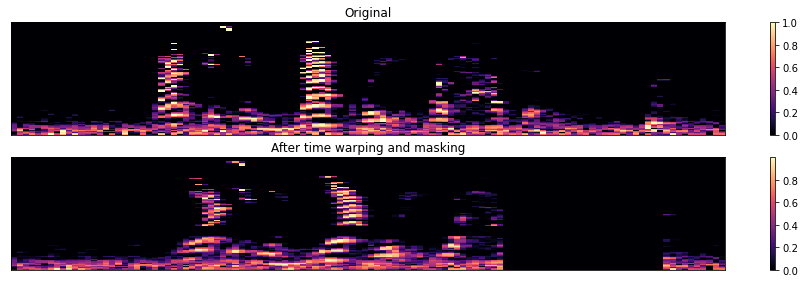

In [100]:
file = train_df["file_id"].iloc[5000]
file_path = os.path.join("challengeA_data", "train", file)
audio, _ = librosa.load(file_path, sr=16000)
mel_specgram = librosa.feature.melspectrogram(y=audio, n_fft=512, hop_length=512, sr=16000)
mel_specgram = librosa.amplitude_to_db(mel_specgram, ref=np.max)
norm_mel_specgram = []
for row in mel_specgram:
    norm_row = (row - row.min()) / (row.max() - row.min() + 1e-9)
    norm_mel_specgram.append(norm_row)
norm_mel_specgram = np.array(norm_mel_specgram)
print(norm_mel_specgram.shape)

plt.figure(figsize=(16, 12))
num_plots = 5

# original
plt.subplot(num_plots, 1, 1)
plt.title("Original")
librosa.display.specshow(norm_mel_specgram)
plt.colorbar()

# with time ask
specAugmenter = SpecAugment(policy=None)
norm_mel_specgram = specAugmenter.apply_all(norm_mel_specgram)

plt.subplot(num_plots, 1, 2)
librosa.display.specshow(norm_mel_specgram)
plt.title("After time warping and masking")
plt.colorbar()

Now, I produce 1 new mel-spectrogram for every instance in the dataset, using the already saved mel-spectrograms contained in the directory "./challengeA_data/mel_spectrogram".

In [45]:
def get_num_files(directory, suffix, warped_only=False):
    total = 0
    for root, dirs, files in os.walk(directory):
        if warped_only:
            total += len([file for file in files if file.endswith("_warped.npy")])
        else:
            total += len([file for file in files if file.endswith(".npy")])
    return total

In [101]:
mel_specgram_path = "challengeA_data/mel_spectrogram"
specAugmenter = SpecAugment(policy=None)
    
files_to_process  = []
for root, dirs, files in os.walk("challengeA_data/mel_spectrogram"):
    files_to_process += [os.path.join(root, file) for file in files if file.endswith(".npy") and not (file.endswith("_warped.npy") or file.endswith("_noise.npy"))]
files_to_process.sort()

num_files = len(files_to_process)
num_files_already_processed = get_num_files(mel_specgram_path, ".npy", warped_only=True)
num_files_to_process = num_files - num_files_already_processed
batch_size = 50
num_batches =  num_files_to_process // batch_size
# if there are left over files, add an extra batch.
if num_batches * batch_size < num_files_to_process:
    num_batches += 1

files_processed = num_files_already_processed
for batch in range(num_batches):
    start_index = num_files_already_processed + (batch * batch_size)
    for file_index in range(start_index, min(num_files, start_index+batch_size)):
        file_path = files_to_process[file_index]
        # because the emotion is the parent directory of the file, the emotion can be obtained by 
        # accessing the second last element of the path.
        emotion = file_path.split("/")[-2]
        file = file_path.split("/")[-1]
        
        mel_specgram = np.load(file_path)
        
        warped_specgram = specAugmenter.apply_all(mel_specgram)
        mel_specgram_file = file.replace(".npy", "_warped.npy")  
        
        save_directory = os.path.join(os.getcwd(), mel_specgram_path, emotion)
        save_path = os.path.join(save_directory, mel_specgram_file)
        np.save(save_path, warped_specgram)
        
        files_processed += 1

    percentage_complete = round(files_processed / num_files * 100, 2)
    clear_output(wait=True)
    display(f"Saving files to ./challengeA_data/mel_spectrogram" + '.'*(batch%3+1))
    display(f"Progress: {percentage_complete}%")
    
print("Complete")

'Saving files to ./challengeA_data/mel_spectrogram.'

'Progress: 100.0'

Complete


In [102]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        num_files_to_display = 3
        for f in files[:num_files_to_display]:
            if f.startswith("."): continue
            print('{}{}'.format(subindent, f))
        else:
            print('{}{}'.format(subindent, "..."))

The folder structure now looks like this:

In [103]:
list_files("challengeA_data/mel_spectrogram")

mel_spectrogram/
    ...
    happy/
        c60852b1-4474-43d9-a5dc-e1885d513c28.npy
        675cfafa-4374-4435-994e-f054309879e9_warped.npy
        efb6e436-ebf6-4927-ad5f-5224c5a25e87.npy
        ...
    fear/
        3533f5c8-743b-4ad7-94cf-653de1c9413e.npy
        0813ad8a-9abe-487f-9ca2-19a1c1d3e508_warped.npy
        51ba0893-16ee-40a7-9831-c81eb95501f8_noise.npy
        ...
    surprise/
        3979d7cf-4419-4dfd-a2cb-c8eb2f84723c_noise.npy
        26c6e04d-13f4-479a-b0e9-fd7c34377f2b_noise.npy
        2ff0e956-247f-4fa1-85e4-4c79817b16f2.npy
        ...
    sadness/
        e70669d1-b4d2-4e0f-a518-7de88c4835b5_noise.npy
        8b3a8f76-0546-4d21-b12d-b1535fee6fbd_noise.npy
        49103c2e-5eac-4c29-8028-27d66ea8b051_noise.npy
        ...
    neutral/
        ffddeb39-1ae6-4296-9580-374c12e0a2f2_warped.npy
        3fcf79ba-7498-4af7-b73a-47d606288c9f.npy
        f3cd5737-4305-46e8-b07b-28b14d792a75.npy
        ...
    angry/
        b189e115-4068-4c29-b0da-e85f620a1d70_warped

In [104]:
total_examples = get_num_files(mel_specgram_path, suffix=".npy")
print(f"Total number of mel-spectrograms: {total_examples}")

Total number of mel-spectrograms: 24024


I managed to create an additional 13914 (10110 mel-spectrograms and 3804 noisy audio files) examples on top of the original 10110, giving a grand total of 24024 examples to work with. It is worth noting, however, that all the training data was augmented at least once. This has important implications in the training phase, because when validating the performance of the model, it's extremely important that the validation data is held out completely from training, including any of the validation data that was augmented.